In [1]:
# import the necessary packages
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2
import os
import sys
import tensorflow as tf

2024-02-02 03:43:08.850345: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


In [2]:
IMAGE_SIZE=224

In [3]:
#CHANGE THESE PATHS ACCORDING TO THE PATH IN YOUR SYSTEM
DATASET_PATH='dataset-realwaste-hierarchical'
H5DATASET_FOLDER='h5-dataset-realwaste-flat'
TARGET_HDF5_DATASET_PATH=H5DATASET_FOLDER+'realwaste-dataset-SIZE'+str(IMAGE_SIZE)+'.hdf5'
OUTPUT_STATS_FILE=H5DATASET_FOLDER+'realwaste-dataset-SIZE'+str(IMAGE_SIZE)+'.hdf5.csv'

In [4]:
class_label_string_length="S36"

In [5]:
from anis_koubaa_udemy_computer_vision_lib import *

In [6]:
classes=os.listdir(DATASET_PATH)
classes.sort()
print(classes)

['NonRecyclable', 'Organic', 'Recyclable']


In [7]:
print(DATASET_PATH)
# directory_depth=0 -> flat classifier
data, labels=load_rgb_data(DATASET_PATH,
                             IMAGE_SIZE, 
                             directory_depth=0, 
                             max_number_of_images=None, 
                             shuffle=True)

dataset-realwaste-hierarchical
Loading images...
loaded  50  images so far ...
loaded  100  images so far ...
loaded  150  images so far ...
loaded  200  images so far ...
loaded  250  images so far ...
loaded  300  images so far ...
loaded  350  images so far ...
loaded  400  images so far ...
loaded  450  images so far ...
loaded  500  images so far ...
loaded  550  images so far ...
loaded  600  images so far ...
loaded  650  images so far ...
loaded  700  images so far ...
loaded  750  images so far ...
loaded  800  images so far ...
loaded  850  images so far ...
loaded  900  images so far ...
loaded  950  images so far ...
loaded  1000  images so far ...
loaded  1050  images so far ...
loaded  1100  images so far ...
loaded  1150  images so far ...
loaded  1200  images so far ...
loaded  1250  images so far ...
loaded  1300  images so far ...
loaded  1350  images so far ...
loaded  1400  images so far ...
loaded  1450  images so far ...
loaded  1500  images so far ...
loaded  155

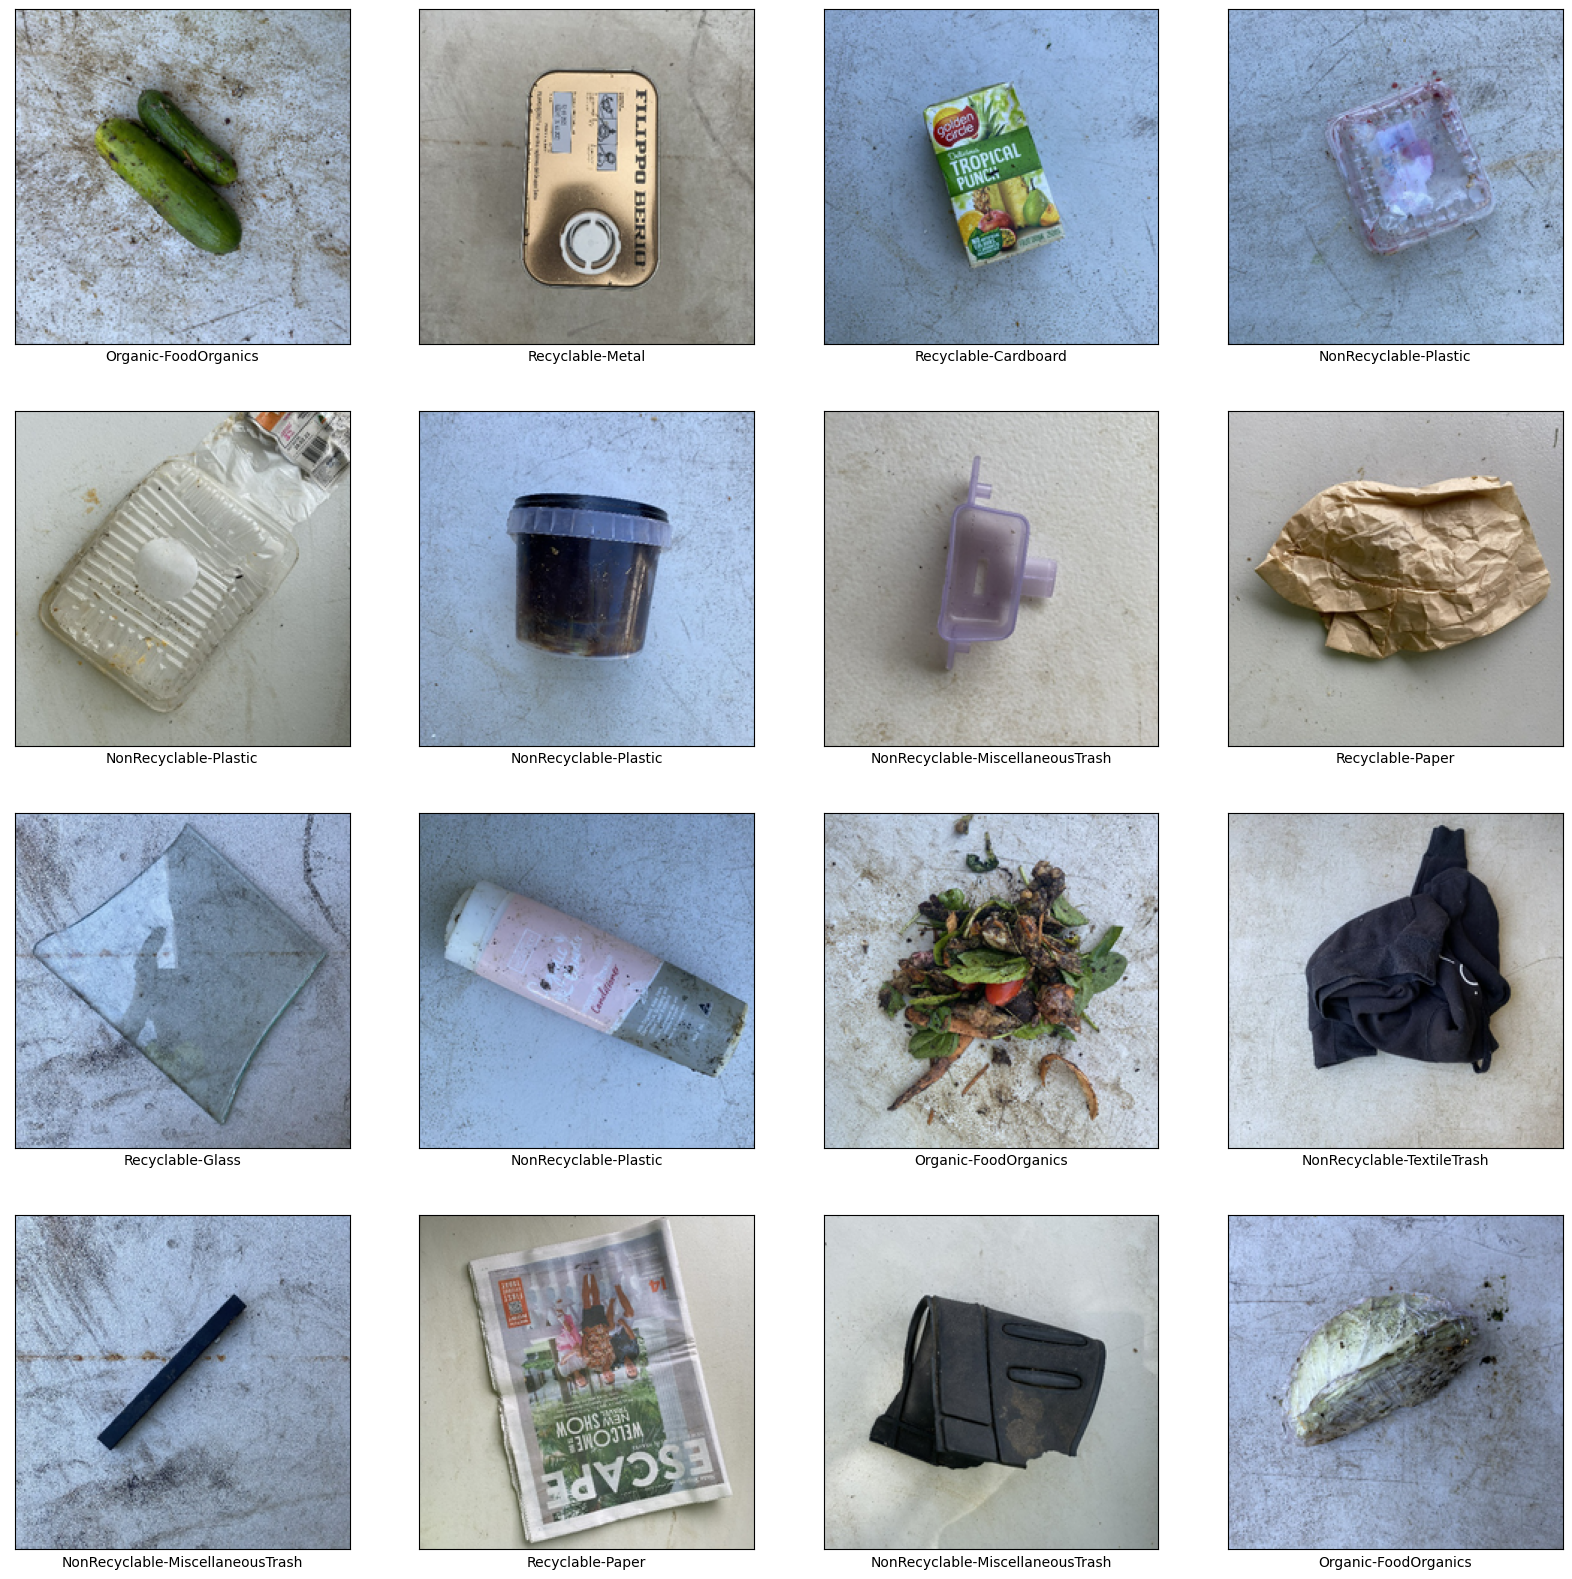

In [8]:
plot_sample_from_dataset(data, labels,
                           rows=4, colums=4, 
                           width=20,height=20)

In [9]:
number_of_classes=len(np.unique(labels))
number_of_classes

9

Label = Recyclable-Metal
image shape:  (224, 224, 3)


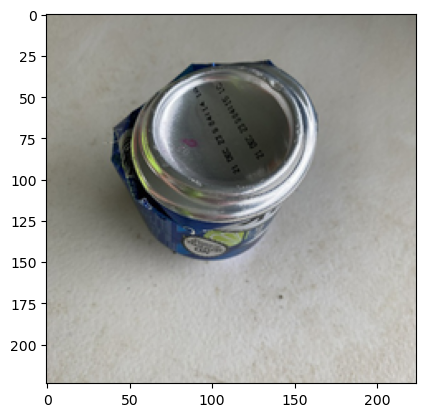

In [10]:
display_image(data, labels, index=888)

In [11]:
display_dataset_shape(data, labels)

Shape of images:  (4752, 224, 224, 3)
Shape of labels:  (4752,)


In [12]:
display_dataset_folders(DATASET_PATH)

['NonRecyclable', 'Organic', 'Recyclable']


In [13]:
data_images=normalize_data(data)

normalize data


In [14]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from tensorflow.keras.utils import to_categorical

# perform one-hot encoding on the labels
print ("labels: ", labels[:10])
lb = LabelBinarizer()
binary_labels = lb.fit_transform(labels)
print ("train_binary_labels after Binarizer: ", binary_labels[:10])

labels:  ['Organic-FoodOrganics' 'Recyclable-Metal' 'Recyclable-Cardboard'
 'NonRecyclable-Plastic' 'NonRecyclable-Plastic' 'NonRecyclable-Plastic'
 'NonRecyclable-MiscellaneousTrash' 'Recyclable-Paper' 'Recyclable-Glass'
 'NonRecyclable-Plastic']
train_binary_labels after Binarizer:  [[0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 1 0 0 0]
 [0 1 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 1 0 0]
 [0 1 0 0 0 0 0 0 0]]


In [15]:
#create dictionnary
import collections
car_dict={}

for i,label in enumerate(binary_labels):
    #print('---')
    #print(i)
    #print(np.argmax(label))
    #print(testLabels[i])
    car_dict[np.argmax(label)]=labels[i]
    #print(car_dict)
    if (len(car_dict)==number_of_classes):
        break
#print(sorted(car_dict.items()))
print(car_dict)

{3: 'Organic-FoodOrganics', 7: 'Recyclable-Metal', 5: 'Recyclable-Cardboard', 1: 'NonRecyclable-Plastic', 0: 'NonRecyclable-MiscellaneousTrash', 8: 'Recyclable-Paper', 6: 'Recyclable-Glass', 2: 'NonRecyclable-TextileTrash', 4: 'Organic-Vegetation'}


In [16]:
import h5py
from pathlib import Path

#create the folder if it does not exist
#Path(H5DATASET_FOLDER).mkdir(parents=True, exist_ok=True)

hf=h5py.File(TARGET_HDF5_DATASET_PATH, 'w')

images_shape=data.shape
labels_shape=labels.shape

In [17]:
hf.create_dataset("images",
                  shape=images_shape,
                  maxshape=images_shape,
                  compression="gzip",
                  compression_opts=9,
                  data=data_images)

print("Done")

Done


In [18]:
labels_in_ascii= [n.encode('unicode_escape') for n in labels]
#print(labels_in_ascii)

In [19]:
hf.create_dataset("labels",
            shape=labels_shape,
            compression="gzip",
            compression_opts=9,
            data=labels_in_ascii,dtype=class_label_string_length
            )

<HDF5 dataset "labels": shape (4752,), type "|S36">

In [20]:
hf.create_dataset("binary_labels",
                  shape=binary_labels.shape,
                  maxshape=binary_labels.shape,
                  compression="gzip",
                  compression_opts=9,
                  data=binary_labels)

<HDF5 dataset "binary_labels": shape (4752, 9), type "<i8">

In [21]:
hf.close()

In [22]:
hf = h5py.File(TARGET_HDF5_DATASET_PATH, "r")

In [23]:
labels_in_ascii = np.array(hf["labels"]).astype(class_label_string_length)

In [24]:
#get labels in string format: decode from ASCII
labels = [n.decode('unicode_escape') for n in labels_in_ascii]
#print(asciiList)
print ('number of labels:',len(labels))

number of labels: 4752


In [25]:
np.unique(labels)

array(['NonRecyclable-MiscellaneousTrash', 'NonRecyclable-Plastic',
       'NonRecyclable-TextileTrash', 'Organic-FoodOrganics',
       'Organic-Vegetation', 'Recyclable-Cardboard', 'Recyclable-Glass',
       'Recyclable-Metal', 'Recyclable-Paper'], dtype='<U32')

In [26]:
hf.close()

In [27]:
def get_data_distribution(IMAGE_DIRECTORY, directory_depth=2, output_file=None,plot_stats=True):
    print("Loading images...")
    #list structure to collect the statistics
    stats=[]

    for folder,directory_name,file_name in os.walk(IMAGE_DIRECTORY):
        if (len(file_name)!=0):
          if(directory_depth!=0):
              #print (folder, directory_name, file_name)
            folders_list =folder.split('/')[0:-1]
          else:
            folders_list =folder.split('/')[-1:]
            
          #print(folders_list)
          label = folders_list[-directory_depth]
          #print (label)
          for i in range(len(file_name)):
                image_name = file_name[i]
                image_path = os.path.join(folder, image_name)
                if ('.DS_Store' not in image_path):
                #print(image_path)
                    try:
                        img = Image.open(image_path)
                        #print(image_path)
                        rgbimg = Image.new("RGB", img.size)
                        rgbimg.paste(img)
                        img=rgbimg


                        width,height = img.size
                        #get the size of the image in KB
                        size_kb=os.stat(image_path).st_size/1000
                        #add the size to a list of sizes to be 
                        stats.append([label,os.path.basename(image_path),width,height,size_kb])
                        #print(stats)
                    except Exception:
                        pass

    if (output_file is not None):
        #convert the list into a dataframe to make it easy to save into a CSV
        stats_dataframe = pd.DataFrame(stats,columns=['Class','Filename','Width','Height','Size_in_KB'])
        stats_dataframe.to_csv(output_file,index=False)
        print("Stats collected and saved in .",output_file)
    else:
        print("Stats collected");


    return stats

In [28]:

stats = get_data_distribution(DATASET_PATH, directory_depth=0,output_file=OUTPUT_STATS_FILE)
#print(stats)

Loading images...


Stats collected and saved in . h5-dataset-realwaste-flatrealwaste-dataset-SIZE224.hdf5.csv


9  classes found in the dataset
Images of the whole dataset have an average size of  144.8460382996633
sizes of class [ NonRecyclable-MiscellaneousTrash ] have an average size of  148.57983434343436
sizes of class [ NonRecyclable-TextileTrash ] have an average size of  139.5670251572327
sizes of class [ NonRecyclable-Plastic ] have an average size of  143.4269305103149
sizes of class [ Organic-Vegetation ] have an average size of  207.17728211009174
sizes of class [ Organic-FoodOrganics ] have an average size of  186.14151094890514
sizes of class [ Recyclable-Paper ] have an average size of  131.990814
sizes of class [ Recyclable-Glass ] have an average size of  118.09025476190476
sizes of class [ Recyclable-Metal ] have an average size of  125.46781772151898
sizes of class [ Recyclable-Cardboard ] have an average size of  123.07265292841649
number of instances in class [ NonRecyclable-MiscellaneousTrash ] is  495
number of instances in class [ NonRecyclable-TextileTrash ] is  318
numb

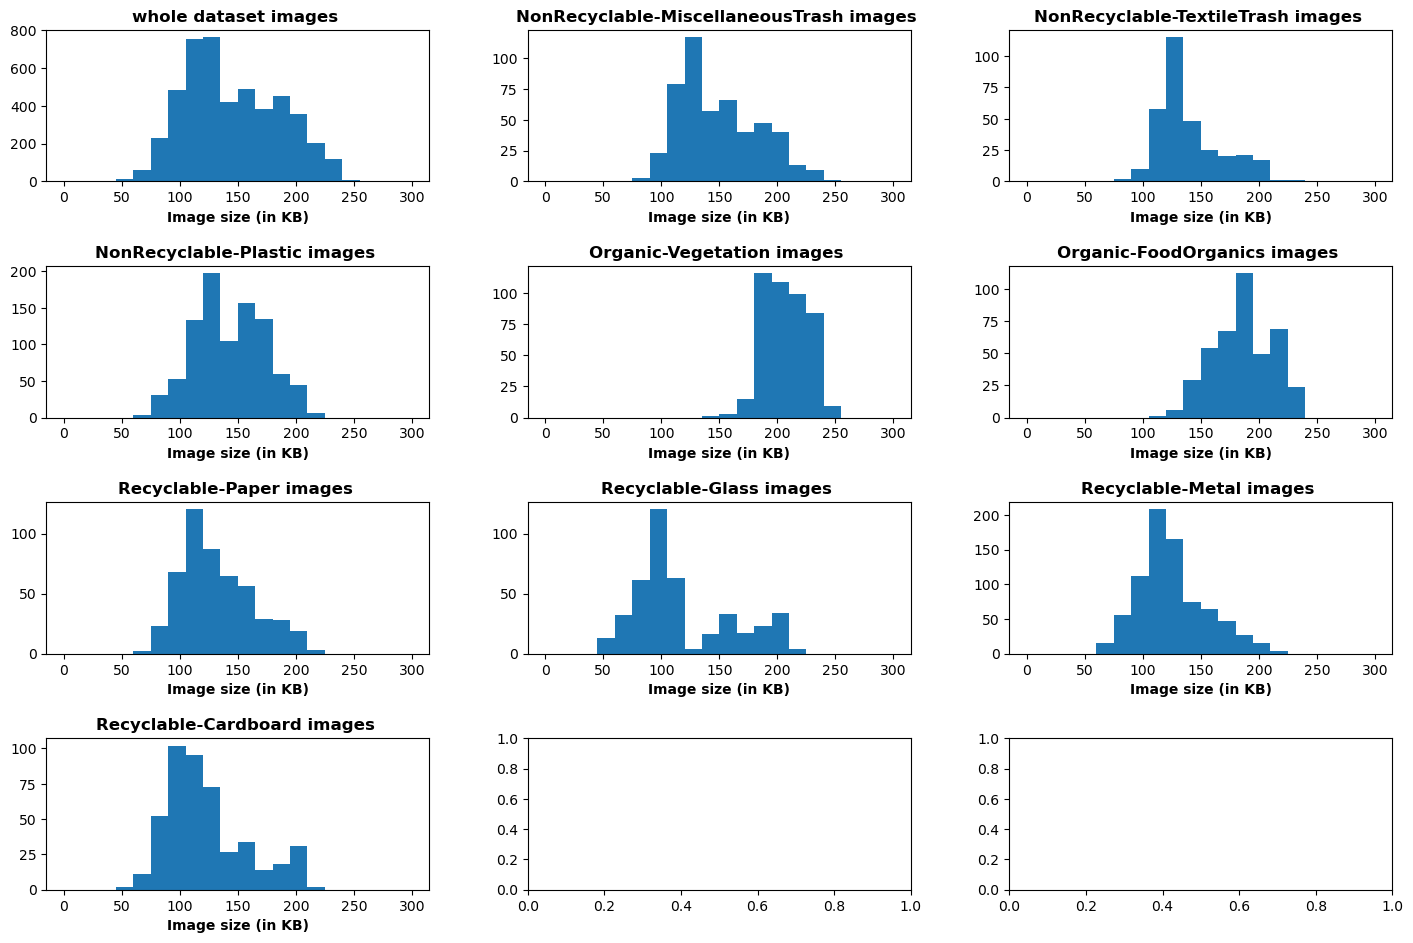

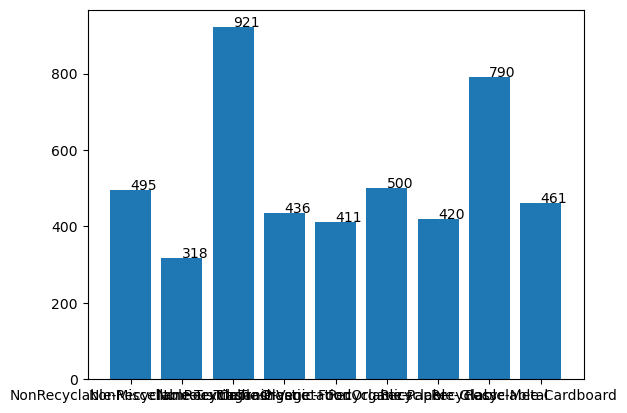

In [29]:
plot_dataset_distribution (stats, num_cols=3, width=15, height=10, histogram_bins = 20, histogram_range=[0, 300], figure_padding=4)